# Practice - Class 9

Erick Hernández Silva A01750170

Israel Sánchez Miranda A01378705

We will implement a genetic algorithm to solve:
\begin{equation}
\max_{x,y\in[-1,1]}x^2+y^2
\end{equation}

Subjected to the following constraints:
\begin{equation}
\tag{2}
h(x,y)=x^2+y^2=\frac12
\end{equation}

\begin{equation}
\tag{3}
g(x,y)=x-y\leq0
\end{equation}

Import the necessary libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

We now define the constants of the problem.

In [3]:
BOUNDS = [-1, 1]
PC_BINARY = 0.9  # Crossover probability for binary encoding
PC_REAL = 0.9  # Crossover probability for real encoding
PM_BINARY = 1 / 16  # Mutation probability for binary encoding
PM_REAL = 1 / 16  # Mutation probability for real encoding
N_C = 20  # Distribution index for SBX crossover

We then define the fitness function. Since we are dealing with a maximization problem, we need to flip equation $(1)$ such that:
\begin{equation}
\tag{4}
\bar f(x,y)=-(x^2+y^2)
\end{equation}

In [4]:
def function (individual):
  x, y = individual
  return -(x**2 + y**2)

We now plot the landscape of the fitness function.

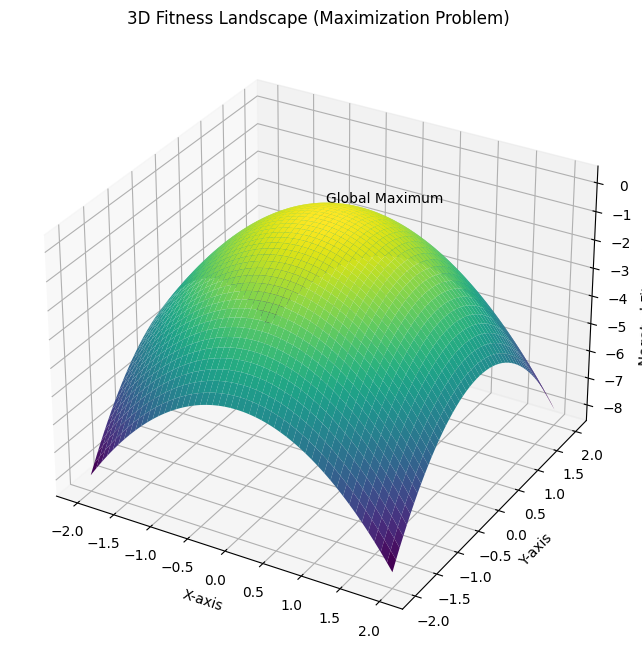

In [5]:
# Create a grid of x and y values
x = np.linspace(-2, 2, 400)  # Change range and resolution as needed
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)

# Calculate the fitness values for the grid using the negated function
Z = function((X, Y))

# Plotting the 3D landscape for maximization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title('3D Fitness Landscape (Maximization Problem)')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Negated Fitness Value')

# Mark the global maximum
ax.scatter(0, 0, 0, color='red', marker='o', s=100)  # Mark the global maximum
ax.text(0, 0, 0.5, 'Global Maximum', color='black')

plt.show()

Since the solution vector is in $\R^2$ we make a contour plot for easier visualization.

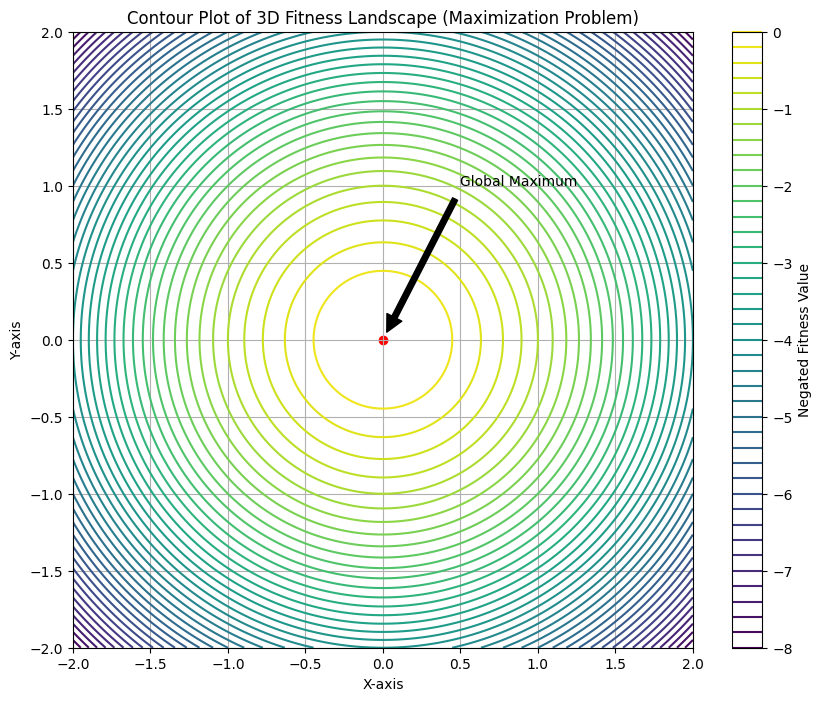

In [6]:
# Create a grid of x and y values
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)

# Calculate the fitness values for the grid using the negated function
Z = function((X, Y))

# Plotting the contour plot for the maximization problem
plt.figure(figsize=(10, 8))
contour = plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, label='Negated Fitness Value')
plt.title('Contour Plot of 3D Fitness Landscape (Maximization Problem)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.scatter(0, 0, color='red', marker='o')  # Mark the global maximum
plt.annotate('Global Maximum', xy=(0, 0), xytext=(0.5, 1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid()
plt.show()

For our algorithm we apply real enoding, thus we use SBX crossover and PM mutation. For selection we apply a binary tournament. The code for this mechanisms is provided below:

In [7]:
# Real encoding crossover (SBX) and mutation
def sbx_crossover(p1, p2, nc):
  child1, child2 = np.zeros_like(p1), np.zeros_like(p2)
  for i in range(len(p1)):
    u = np.random.rand()
    if u <= 0.5:
      beta = (2 * u)**(1 / (nc + 1))
    else:
      beta = (1 / (2 * (1 - u)))**(1 / (nc + 1))
    child1[i] = 0.5 * ((1 + beta) * p1[i] + (1 - beta) * p2[i])
    child2[i] = 0.5 * ((1 - beta) * p1[i] + (1 + beta) * p2[i])
  return child1, child2

def pm_mutation(chrom, bounds, gen):
  # Select a random index in the chromosome
  mutation_index = np.random.randint(0, len(chrom))
  
  # Compute delta based on the selected allele
  delta = abs(min(chrom[mutation_index] - bounds[0], bounds[1] - chrom[mutation_index]) / (bounds[0] - bounds[1]))
  nm = 100 + gen
  delta_q = 0

  u = np.random.rand()
  
  # Apply the mutation formula based on delta
  if u < 0.5:
    delta_q = (2 * u + (1 - 2 * u) * (1 - delta) ** (nm + 1))**(1 / (nm + 1)) - 1
  else:
    delta_q = 1 - (2 * (1 - u) + (2 * (u - 0.5)) * (1 - delta) ** (nm + 1))**(1 / (nm + 1))
  
  # Apply mutation to the selected allele
  chrom[mutation_index] += delta_q * (bounds[1] - bounds[0])
  chrom[mutation_index] = np.clip(chrom[mutation_index], bounds[0], bounds[1])  # Ensure the value stays within bounds
    
  return chrom

def binary_tournament_selection(population, fitness):
    population_copy = population[:]  # Create a copy of the population to manipulate
    fitness_copy = fitness[:]        # Copy fitness array to manipulate
    
    while len(population_copy) > 1:
        winner_arr = []
        
        # Perform selection in pairs
        while len(population_copy) >= 2:
            # Randomly select two individuals
            first_idx, second_idx = np.random.choice(len(population_copy), size=2, replace=False)
            
            first_individual = population_copy[first_idx]
            second_individual = population_copy[second_idx]
            
            # Compare their fitness and select the winner
            if fitness_copy[first_idx] > fitness_copy[second_idx]:
                winner_arr.append(first_individual)
            else:
                winner_arr.append(second_individual)
            
            # Remove both individuals from the population
            del population_copy[max(first_idx, second_idx)]
            del fitness_copy[max(first_idx, second_idx)]
            del population_copy[min(first_idx, second_idx)]
            del fitness_copy[min(first_idx, second_idx)]

        # If odd number of individuals, automatically advance the last individual
        if len(population_copy) == 1:
            winner_arr.append(population_copy[0])
        
        # Set the population for the next round
        population_copy = winner_arr
        fitness_copy = [fitness[i] for i in range(len(population_copy))]

    # Return the last remaining winner
    return population_copy[0]

We define a simple genetic algorithm which consists on the following steps: 
1. Randomly initialize the a population with the specified bounds, decision variables and population size.
2. Initialize a loop with the specified number of generations:

   3.1. Calculate the fitness of each individual using a penalization function to handle constraints.

   3.2. Select the parents of the next generation based on their fitness using binary tournament selection.

   3.3. If probabilities are met, crossover the two parent to make two children, if not, the parents become the children of the next generation.

   3.4. If probabilities are met, mutate the children generated in the step before.

   3.5. Now the new population is the two children generated by the steps before.

   3.6. Track the best fitness of the current generation and store it.

   3.7. Check for stagnation, if no significative changehas been made in the last 5 generations (below a specified threshold of $1\times10^{-6}$), then early stop the process.
   
3. Return the convergence array, an array with the best fitness per generation and the solution achieved by the algorithm.

Using a penalty function to handle the constraints in this problem can be more efficient and flexible, we define the following reasons to use this constraint-handling technique:

1. **Preserving Diversity in the Population**  
The penalty function allows individuals that slightly violate the constraints to remain in the population, albeit with a reduced fitness value. This helps avoid the loss of diversity, which is important in genetic algorithms. If infeasible solutions are immediately eliminated (as with the death penalty), the algorithm could stagnate at suboptimal solutions because it does not explore areas close to the boundaries of the constraints.

2. **Relaxing Constraints Initially**  
During the early generations of the algorithm, it may be beneficial to allow some solutions to slightly violate the constraints to better explore the search space. Over time, as the algorithm evolves, the penalty will progressively discard infeasible solutions, guiding the algorithm toward the feasible region.

3. **Smooth Penalty Gradient**  
Penalty functions add a gentle penalty to solutions that violate the constraints rather than eliminating them outright. This creates a fitness gradient, where solutions that slightly violate the constraints are penalized less than those that violate them severely, helping the algorithm to iteratively improve.

4. **Flexibility to Handle Multiple Constraints**  
This problem has both an equality constraint $h(x, y) = \frac{1}{2}$ and an inequality constraint $g(x, y) \leq 0$. The penalty function allows for flexible handling of both by applying different weights to each based on the severity of their violation, with terms like:

   $
   fitness(x) = f(x) - \left( c_1 \sum_i G_i(x) + c_2 \sum_i H_i(x) \right)
   $

   This allows each constraint to be treated differently according to its importance or difficulty to satisfy.

5. **Efficiency in Global Search**  
The penalty function not only punishes infeasible solutions but can also help guide the algorithm toward optimal solutions within the feasible region. This is useful when the feasible region is small or difficult to find, such as in the case of nonlinear constraints like \(( h(x, y) = x^2 + y^2 = \frac{1}{2} )\).

For these reasons, the penalty function is suitable as it balances the exploration of solutions close to the feasibility boundary and gradually guides the algorithm toward feasible and optimal solutions.


In [8]:
# Genetic Algorithm framework
def genetic_algorithm(fitness_function, bounds, dim, ineq_constraints, eq_constraints, con1=4, con2=3, beta=1, gamma=2, n_generations=100, pop_size=100, stop_threshold=1e-6, stagnation_generations=5, verbose=False):
    # Create initial population as real values
    population = [np.random.uniform(bounds[0], bounds[1], dim) for _ in range(pop_size)]
    
    if verbose:
        print(f'Original population: {population}')

    best_fitness_per_gen = []
    
    for gen in range(n_generations):
        # Clip the values of the real population to ensure they stay within bounds
        real_population = [np.clip(ind, bounds[0], bounds[1]) for ind in population]

        if verbose:
            print(f'Clipped population (generation {gen + 1}): {real_population}')

        # Evaluate fitness using penalty function
        fitness = []
        for individual in real_population:
          G_i = []
          H_i = []
          for constraint in ineq_constraints:
              G_i.append(max(0, constraint(individual))**beta)
          for constraint in eq_constraints:
              H_i.append(np.abs(constraint(individual))**gamma)

          fitness.append(fitness_function(individual) - (con1 * np.sum(G_i) + con2 * np.sum(H_i)))
    
        new_population = []
        for _ in range(pop_size // 2):
            p1 = binary_tournament_selection(population, fitness)
            p2 = binary_tournament_selection(population, fitness)
            if np.random.rand() < PC_REAL:
                c1, c2 = sbx_crossover(p1, p2, N_C)
            else:
                c1, c2 = p1, p2
            if np.random.rand() < PM_REAL:
                c1 = pm_mutation(c1, bounds, gen)
                c2 = pm_mutation(c2, bounds, gen)
            new_population.extend([c1, c2])
        population = new_population

        # Track best fitness
        best_fitness = max(fitness)
        best_solution_index = fitness.index(best_fitness)
        best_solution = real_population[best_solution_index]
        best_fitness_per_gen.append(best_fitness)

        if verbose:
            print(f"Generation {gen + 1}, Best Fitness: {best_fitness}")

        # Check for stagnation (early stopping)
        if gen >= stagnation_generations:
            recent_fitness = best_fitness_per_gen[-stagnation_generations:]
            fitness_change = max(recent_fitness) - min(recent_fitness)

            if fitness_change < stop_threshold and verbose:
                print(f"Early stopping at generation {gen + 1} due to insufficient improvement.")
                break

    return best_fitness_per_gen, best_solution

We now define the constraints for the problem.

In [9]:
def first_constraint(individual): 
  return individual [0] - individual[1]

In [10]:
def second_constraint(individual):
  return individual[0] ** 2 + individual[1] ** 2  - 0.5

Finally, we apply the GA over the problem with the given connstraints.

In [11]:
_, ga_result = genetic_algorithm(
  function,
  BOUNDS,
  2,
  [first_constraint],
  [second_constraint]
)

print(f'Solution found in: {ga_result}')

Solution found in: [-0.53694688  0.21218241]


For better visuualization, we plot the achieved solution in the contour plot next to the global minimum.

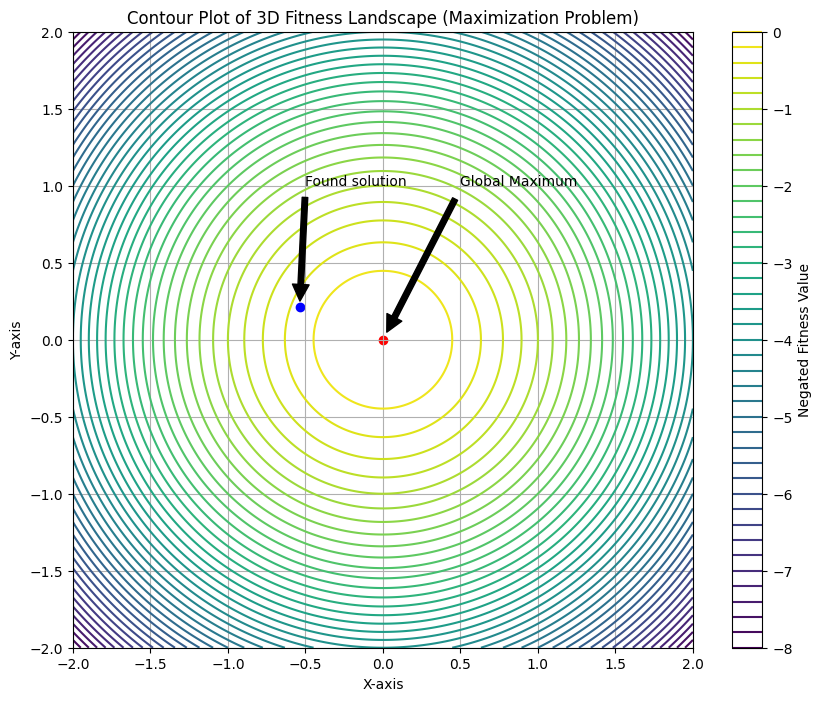

In [12]:
# Create a grid of x and y values
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)

# Calculate the fitness values for the grid using the negated function
Z = function((X, Y))

# Plotting the contour plot for the maximization problem
plt.figure(figsize=(10, 8))
contour = plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, label='Negated Fitness Value')
plt.title('Contour Plot of 3D Fitness Landscape (Maximization Problem)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.scatter(0, 0, color='red', marker='o')  # Mark the global maximum
plt.scatter(ga_result[0], ga_result[1], color='blue', marker='o')  # Mark the found solution
plt.annotate('Global Maximum', xy=(0, 0), xytext=(0.5, 1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Found solution', xy=(ga_result[0], ga_result[1]), xytext=(-0.5, 1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid()
plt.show()